# Predicting Turnover

#### Why Does Turnover Matter?
Good analytics practice is to make sure you're focusing on something that matters.  The goal of analytics in any corporate function is to make better decisions, so why do companies and HR departments want to make better decisions when it comes to turnover?  The answer to this likely varies by company, however one common string is that turnover is expensive for companies.  Like many things in HR, measurement isn't always obvious, turnover is no different.  Some parts of turnover can be objectively measured, the cost of the Talent Acquisition function and their time allocation for net new hires compared to backfills.  Other measures are a bit more subjective and rely on research to estimate costs.  An example of this is the productivity lost for a position being open.  Regardless of the measurement, most leaders believe that turnover is expensive to their company and that reducing it will have a positive impact on their bottom line.  

While the focus of this book isn't on how to run your People Analytics function, more and more experts and pointing out how critical it is that the analytics HR is producing are directly tied to the overall business objectives.

## Two Methodologies for Predicting Turnover

Based on my research and experience, there are two primary methodologies for building a predictive model that predicts employee turnover:  *Survival Analysis* and *Turnover Risk in X Time Period*

#### Survival Analysis
This will not be the methodology for the code in the chapter, however I still want to at least briefly discuss the approach as it is best to understand your options and know *why* this survival analysis methodology may not be the best analytics tool for the turnover prediction business problem.

The survival analysis concept is simple.  How long do people stay after they start with our company?  The value of this should be quite apparent.  If you could incorporate a model into your talent acquisition process that could predict how long someone would stay at a company with even moderate accuracy, your model could produce significant value back to your company.  This is one of the greatest benefits to this analysis approach, the interpretation of the results are intuitive and easy to communicate to non-technical audiences.  The results could be communicated as “we expect candidate A to stay for X years and candidate B to stay for Y years”.  This is simple and easy for almost any audience to understand!

Unfortunately, there are some significant limitations with survival analysis.  The most significant is data availability.  To properly set up a survival analysis model, you will want to have data for all of your employees for the entirety of their tenure.  For legacy companies that have been around for 50+ years and have long tenured employees, this is likely an unrealistic expectation given the number of HRIS’s and a probability of some longer tenured employees starting when records were mostly paper.  For newer companies started within the last 20 years, you may have the opposite problem, you don’t have enough longer tenured employees to do a survival analysis.  In both cases, even if the necessary data can be utilized, the emergence of data privacy laws like GDPR will only become more restrictive in regards to data retention.  In summary, most companies probably don’t have the necessary data to utilize survival analysis for predicting turnover and those that do may be required to anonymize or delete the data necessary for survival analysis. 

#### Turnover Risk in X Time Period
The code in this chapter uses this methodology.  In general, this approach is more flexible to various company’s needs and is more conductive for informing interventions to reduce turnover risk.

This methodology requires some what of a mindset shift than is typically leveraged by humans.  Humans are more comfortable in speaking in absolutes.  When it comes to predictive modeling (and specifically this approach to predicting turnover risk), this can be a great cause of frustration between the analytics team and the business user trying to interpret the results.   The output from this approach is a probability of turnover in the time period you have set in the model.  No matter how cool your model is, you will rarely be able to (or want to) speak in absolutes.  For help with not speaking/thinking in absolutes, [*Thinking in Bets*]( https://www.amazon.com/Thinking-Bets-Making-Smarter-Decisions/dp/0735216355) by Annie Duke is a book I would recommend!

As stated above, the flexibility of this approach is probably its biggest benefit.  Once you have defined what 1 row equals, you can continue to add additional features (the data science community can’t agree on anything, so feature, column, and attribute all mean the same thing) into the model that you believe will add prediction power and the model will scale.  The model is smart enough to only take what is going to provide predictive power, so you can add the shoe color of all your employees into your model if you want.  If there isn’t any predictive power in employee shoe color, it simply won’t be used in the model.  

At this point, anyone with an I/O Psych background is probably cringing and yelling something along the lines of *“you’re going to start finding correlations that don’t matter, are by chance, or are confounds”*.  This is where model development gets a bit more “squishy” and subjective.  The model we’re using (GBM) will take care of the confounds, which is a handy benefit to a GBM because it is doing feature selection for you as well as removing the potential for human error in feature selection.  However, we still want to be mindful of what features we are putting into the model and how it relates to our use case.

If your use case is related back to an intervention we want to test on our workforce, what would happen if employee shoe color came back as our most important variable?  Would you really try an experiment that changes the shoe color of some of your employees and check the change in turnover?  Good luck getting your leaders to approve that!

A good rule of thumb to follow is a yes to the following questions:
1. *Is there is already research done on your feature in question?* There are a lot of really smart people who have already done a ton of research on turnover.  If they have already found a relationship between your feature and turnover, you should feel comfortable adding the feature into your model.
2. *If this variable returned as one of the most predictive, would you be able to provide a potential reason as to why?* Using the shoe color example again, I’d have a hard time finding an explanation where employee shoe color actually influences shoe color.  Maybe it is a confound for age? (insert joke about dads wearing white Nike shoes)

#### Chapter 3 Overview
This chapter is broken into the following sections
1. Set up your data
2. Pre-Processing before modeling
3. Grid Search and the model
4. Understanding your results
5. Using your model to predict


## Set up your data
Garbage in, garbage out is a common phrase with data and predicting turnover risk is no exception.  However, there even worse consequences with not setting up your data when building a predictive model, this is called *model leakage*.  This is when you’re telling the model the whole or part of the answer with your inputs to the model.  An easy example is including termination date as a feature in your model, you’d be telling the model the answer!

In this section we will be going over the steps to setting up your data in a way that will allow it.  We will be using a generated dataset.  How this dataset was created is outlined in the previous chapter.
1. We will discuss the importance of defining what 1 row in your dataset means
2. Selecting and defining your target variable 
3. Adjust our dataset based on how we define our target variable
4. How to lag our target variable (**very important**)
5. Selecting the columns we want to include in our model
6. How to dummy code non-numeric variables 
7. Discuss feature engineering

You'll likely observe the setting up your data section has the most code associated with it.  This is quite typical as the majority of the work when building a model will come from setting up your data rather than actually building the model.

#### Defining what one row means

First we will import the necessary packages.  In this instance, we only need Pandas.  If you're an R user, Pandas is similar to dplyr.  If you haven't used R or Python before, Pandas is a manipulation/reshaping library.  We rename Pandas as "pd".  This is because each time we want to reference a function within Pandas we only have to write "pd" instead of "pandas".  Naming Pandas "pd" is standard across the Python community.

In [144]:
import pandas as pd
import numpy as np

Now that Pandas is imported, we can use it's function that imports .CSV files.  If you haven't needed to understand the difference between an Excel and CSV file yet, you will now!  Pandas has seperate import functions for a CSV vs. Excel file.  When passing the path of the file, include the entire file path to ensure it knows where to look.

When naming your objects or variables in Python, find the balance between length and descriptiveness.  If you're using extremely long names, it will make your code harder to read and take you longer to write it.  If your names aren't descriptive enough, you or anyone else trying to read your code will have a difficult time understanding what is going where and why.  It is a difficult balance to find, but it becomes easier with time!  When importing a new dataset, I usually call it "df_raw".  Df stands for dataframe and raw indicates it hasn't been manipulated at all.  By doing this, I can redo any manipulations to my dataset without having to reimport the raw data.

If you get an error right away, the first thing to check is if your file is still open.  Depending on where your file is saved, it may need to be closed for it to be loaded via Pandas.

In [145]:
df_raw = pd.read_csv("employee_data_turnover_model.csv")
df_raw.head()

,employee_id,department,gender,job_level,performance_rating,engagement,salary_thousands,tenure_years,age_years,promotion_indicator,record_start_date,record_end_date,termination_indicator,termination_date
0,0,Account/Client Management,Male,Individual Contributor,2.0,3.0,165,49,36,0,1/1/2018,12/31/2018,0,NaN
1,1,Technology,Male,Individual Contributor,4.0,5.0,68,23,25,1,1/1/2018,12/31/2018,0,NaN
2,2,Account/Client Management,Male,Individual Contributor,4.0,5.0,109,11,33,0,1/1/2018,12/31/2018,0,NaN
3,3,Account/Client Management,Male,Individual Contributor,4.0,3.0,143,27,52,0,1/1/2018,12/31/2018,0,NaN
4,4,Account/Client Management,Male,Individual Contributor,3.0,5.0,83,8,34,0,1/1/2018,12/31/2018,0,NaN


As the dataset is loaded from the .CSV file, 1 row equates to a period of time.  The period of time is defined by the columns "record_start_date" and "record_end_date".  This means an employee could have multiple records in our dataset.  While this often complicates our ability to do reporting or basic descriptive statistics on our data, this means more data for our model which is almost always a good thing!  A model that predicts employee turnover can leverage multiple data formats and this framework can be adjusted to account for them.  In this example, we will be taking an approach to further increase the size of our data.

#### Selecting and Defining Target Variable

If you're not familiar with the terminology, a target variable is what we're trying to predict.  The approach we are taking has been defined as "Turnover in X period of time".  This is where we will define what X is equal to.

When defining X, you need to understand the usage of the model results to your company.  If you're using it to test an intervention on the high risk employees to determine if the termination rate for the treatment group can be reduced, what time period is actionable?  As a general rule, if your company is experiencing high turnover, default to a lower time period like 3 months.  This can then be paired with a treatment that accounts for this shorter term view.  If your company is using this model to simply understand the risk of turnover, it may make sense to define multiple values for X and run a model for each value of X.  For example, running a model for 3, 6, 12, and 18 months will provide a more complete view than defining a single value of X.

Because my head isn't in the sand, I also need to acknowledge the data limitations on how you define X as well.  Like in our example, if you only have 1 year of data, you literally can't define X as 18 months.  You won't get great results if you define X as 12 months because you're opening yourself up to yearly seasonality for future years.

For this model, we will define our target variable as turnover in the next 2 months.  When we lag our data you'll see why having only 1 month isn't ideal from an example standpoint.  You'll also see why having 3 months would eliminate 25% of our data vs. the 17% data beginning eliminated with a 2 month target.

#### Adjust Dataset Based on Target Variable Definition
Now that we have defined our target variable as 2 months, we will want to do a *Cartesian Join* to adjust our definition of a row to one row per employee per month.  This means for each month an employee is active they will have a record.  An employee who is active for the entire year ends up with 12 rows.  An employee who terminates in June ends up with 6 rows.

To do this, we will reference a file that has the last date of each month in 2018.  If you're doing this across multiple years, there are some existing lists available online.  You can also create your own list in Python.  The "calendar" library has the tools necessary to generate this programmatically.

In [146]:
sop_month = pd.read_csv("start_of_month.csv")
sop_month

,sop_month
0,1/1/2018
1,2/1/2018
2,3/1/2018
3,4/1/2018
4,5/1/2018
5,6/1/2018
6,7/1/2018
7,8/1/2018
8,9/1/2018
9,10/1/2018


To actually execute this join is annoyingly difficult with just Pandas.  The number of jokes playing on the SQL vs. sequel is amazing.  My favorite is "(sometimes) a SQL is better than the original".  The approach we will use here is quite inefficient but we can get away with because our dataset is relatively small.  We will be joining each date onto every record, blowing up our dataset to 12x it currently is.  Then we'll filter using some conditional logic on the dates.  To simplify this, we will create a dummy column on both datasets to join on.  The type of join we do in this instance won't matter because everything will match to everything.

If your dataset is larger, I'd suggest spinning up a SQL lite database (import sqlite3).  This will enable you do utilize SQL to execute your join with the conditional logic, rather than joining everything and then filtering.

In [147]:
df_raw['for_join'] = 0
sop_month['for_join'] = 0

df_long = pd.merge(df_raw, sop_month, how = 'inner', on='for_join')

To give you some perspective on how much larger our dataset is, see the below.  As I had said above, it is now 12 times larger!

In [148]:
print("Original Employee Data: ", df_raw.shape[0])
print("New Employee Data: ", df_long.shape[0])
print("Number of times larger: ", df_long.shape[0] / df_raw.shape[0])

Original Employee Data:  15222
New Employee Data:  182664
Number of times larger:  12.0


Now we need to filter down our dataset to only the records we want to keep based on the dates being between the appropriate values.  Through my learning of R and Python, dates have always been a point of frustration for myself.  There are a ton of different date types and not all are work together.  In this instance we want to make sure our data types are the same for the dates we will filter on.  They are not, so we will also make the adjustment to our date fields using the Pandas to_datetime() function.

Sometimes the issue with your column not actually being a date is simply annoying, as you'll get an error message that you can use to debug.  However, in other instances if your date has a data type of an object or string, it will run successfully but give you a result you weren't expecting.

In [149]:
df_long['sop_month'] = pd.to_datetime(df_shorter['sop_month'])
df_long['record_start_date'] = pd.to_datetime(df_shorter['record_start_date'])
df_long['record_end_date'] = pd.to_datetime(df_shorter['record_end_date'])

df_shorter = df_long[(df_long['sop_month'] >= df_long['record_start_date']) & (df_long['sop_month'] <= df_long['record_end_date'])]

Taking another look at how much the data reduces and what the new size is compared to the original dataset we imported from CSV.


In [150]:
print("Employee Data After Join: ", df_long.shape[0])
print("Employee Data After Filtering: ", df_shorter.shape[0])
print("Number of times smaller: ", df_long.shape[0] / df_shorter.shape[0])
print("New dataset compared to the original: ", df_shorter.shape[0] / df_raw.shape[0])

Employee Data After Join:  182664
Employee Data After Filtering:  53091
Number of times smaller:  3.4405831496863875
New dataset compared to the original:  3.4877808435159636


#### Lagging the Target Variable
**This is really important!!!**

We're trying to predict the probability of an employee terminating in the next 2 months.  Based on that, we need to have our target variable show in the two months prior to the actual termination record, not the actual row in which the termination occurred.  As I mentioned above about the data loss from extending our time frame for our target variable, each additional month we select, is another month we cannot include in our final dataset because the lagged data doesn't have anywhere to go.  For example, January 2018 is the earliest our dataset goes, so it cannot be lagged anywhere effectively removing it our dataset.  Since we only selected 2 months, we only lose January and February.

We do need to do some prep work for our termination date field.  I'll use employee 31 to demonstrate why.

In [151]:
df_shorter[(df_shorter['employee_id'] == 31)]

,employee_id,department,gender,job_level,performance_rating,engagement,salary_thousands,tenure_years,age_years,promotion_indicator,record_start_date,record_end_date,termination_indicator,termination_date,for_join,sop_month
372,31,Account/Client Management,Female,Individual Contributor,3.0,1.0,119,6,31,0,2018-01-01,2018-07-31,1,7/31/2018 0:00,0,2018-01-01
373,31,Account/Client Management,Female,Individual Contributor,3.0,1.0,119,6,31,0,2018-01-01,2018-07-31,1,7/31/2018 0:00,0,2018-02-01
374,31,Account/Client Management,Female,Individual Contributor,3.0,1.0,119,6,31,0,2018-01-01,2018-07-31,1,7/31/2018 0:00,0,2018-03-01
375,31,Account/Client Management,Female,Individual Contributor,3.0,1.0,119,6,31,0,2018-01-01,2018-07-31,1,7/31/2018 0:00,0,2018-04-01
376,31,Account/Client Management,Female,Individual Contributor,3.0,1.0,119,6,31,0,2018-01-01,2018-07-31,1,7/31/2018 0:00,0,2018-05-01
377,31,Account/Client Management,Female,Individual Contributor,3.0,1.0,119,6,31,0,2018-01-01,2018-07-31,1,7/31/2018 0:00,0,2018-06-01
378,31,Account/Client Management,Female,Individual Contributor,3.0,1.0,119,6,31,0,2018-01-01,2018-07-31,1,7/31/2018 0:00,0,2018-07-01


As you can see in the above, this individual's termination date is shown on every record.  What we want to do is adjust this to only put it in the month in which the individual terminated.  We will do this by extracting the month of the date using Pandas DatetimeIndex() function.

In [152]:
df_shorter['termination_date'] = pd.to_datetime(df_shorter['termination_date'])

df_shorter['termination_indicator'] = pd.DatetimeIndex(df_shorter['termination_date']).month == pd.DatetimeIndex(df_shorter['sop_month']).month

df_shorter[(df_shorter['employee_id'] == 31)]

C:\Users\jason\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\jason\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,employee_id,department,gender,job_level,performance_rating,engagement,salary_thousands,tenure_years,age_years,promotion_indicator,record_start_date,record_end_date,termination_indicator,termination_date,for_join,sop_month
372,31,Account/Client Management,Female,Individual Contributor,3.0,1.0,119,6,31,0,2018-01-01,2018-07-31,False,2018-07-31,0,2018-01-01
373,31,Account/Client Management,Female,Individual Contributor,3.0,1.0,119,6,31,0,2018-01-01,2018-07-31,False,2018-07-31,0,2018-02-01
374,31,Account/Client Management,Female,Individual Contributor,3.0,1.0,119,6,31,0,2018-01-01,2018-07-31,False,2018-07-31,0,2018-03-01
375,31,Account/Client Management,Female,Individual Contributor,3.0,1.0,119,6,31,0,2018-01-01,2018-07-31,False,2018-07-31,0,2018-04-01
376,31,Account/Client Management,Female,Individual Contributor,3.0,1.0,119,6,31,0,2018-01-01,2018-07-31,False,2018-07-31,0,2018-05-01
377,31,Account/Client Management,Female,Individual Contributor,3.0,1.0,119,6,31,0,2018-01-01,2018-07-31,False,2018-07-31,0,2018-06-01
378,31,Account/Client Management,Female,Individual Contributor,3.0,1.0,119,6,31,0,2018-01-01,2018-07-31,True,2018-07-31,0,2018-07-01


As you can see, the termination_indicator column has been updated to only include the termination in the row that represents the time period in which it occured.

Now we will finally get to the point of this section, actually lagging our target variable!  Since we are only lagging by 2 periods, we will take the manual approach and create 2 series.  Each will have the length of our original dataset, so it can be put right back into our data.

In [153]:
df_lagged_1 = df_shorter['termination_indicator'].shift(periods = -1) 
df_lagged_2 = df_shorter['termination_indicator'].shift(periods = -2) 

combined_lists = zip(df_lagged_1, df_lagged_2)

lagged_data = pd.DataFrame(combined_lists, columns = ['lag_1', 'lag_2'])

When possible, it is usually preferred to use math functions as it is usually provides you more flexibility/options.  In the spirit of this, we will replace our True values to 1's and our False values to 0's.  Once we do that, we'll create a new column that is the max value of either of those 2 columns.  This allows us combine the 2 columns into a single value that can be added back onto our dataset.

In [154]:
lagged_data = lagged_data.replace(to_replace = True, value = 1)
lagged_data = lagged_data.replace(to_replace = False, value = 0)

lagged_data['2_month_term'] = lagged_data.max(axis=1)

Last step is to add the column back onto the dataset

In [155]:
df_lagged = df_shorter
df_lagged['2_month_term'] = lagged_data['2_month_term']
df_lagged.head()

C:\Users\jason\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,employee_id,department,gender,job_level,performance_rating,engagement,salary_thousands,tenure_years,age_years,promotion_indicator,record_start_date,record_end_date,termination_indicator,termination_date,for_join,sop_month,2_month_term
0,0,Account/Client Management,Male,Individual Contributor,2.0,3.0,165,49,36,0,2018-01-01,2018-12-31,False,NaT,0,2018-01-01,0.0
9,0,Account/Client Management,Male,Individual Contributor,2.0,3.0,165,49,36,0,2018-01-01,2018-12-31,False,NaT,0,2018-10-01,0.0
10,0,Account/Client Management,Male,Individual Contributor,2.0,3.0,165,49,36,0,2018-01-01,2018-12-31,False,NaT,0,2018-11-01,0.0
11,0,Account/Client Management,Male,Individual Contributor,2.0,3.0,165,49,36,0,2018-01-01,2018-12-31,False,NaT,0,2018-12-01,0.0
12,1,Technology,Male,Individual Contributor,4.0,5.0,68,23,25,1,2018-01-01,2018-12-31,False,NaT,0,2018-01-01,0.0


Now you'll see the newly created column on the back of the dataset.  

As a summary of this section.  When generating predictions that has a time period associated with the prediction, we need to ensure the "right answer" isn't in the field in which it exists, it needs to be moved to the X number of time periods prior.  What we define our time period as will depend on our business case as well as our data.

#### Selecting Columns

Since we've done quite a bit of actions to our data, we want to select only the columns we know we want to include in our model.  Below is a list of the columnns in our dataset.  Before reading on, which columns do you think should be removed and why?

In [156]:
for col in df_lagged.columns:
    print(col)

employee_id
department
gender
job_level
performance_rating
engagement
salary_thousands
tenure_years
age_years
promotion_indicator
record_start_date
record_end_date
termination_indicator
termination_date
for_join
sop_month
2_month_term


I'll start with what not to keep.

*employee_id*: If we included this, our model would be able to pick up quite quickly on who is who and associate that with other records.  We want each observation to be unique, so removing the employee number is critical.

*record_start_date* and *record_end_date*: These don't represent anything of meaning in our dataset anymore now that we have sop_month, so they can be removed.

*termination_indicator*: Since we have lagged our termination data and put it into 2_month_term, this column represents terminations in a way that we don't want so it should be removed.

*termination_date*: Similar to termination_indicator, we had to manipulate this field to make it into something else we need.

*for_join*: This columns purpose was to join our data with the sop_month dates.  Since this has been done, we can now remove it.

Now that we know which columns we don't want, let's select the ones we do want.  Something of note, it is best practice to put your target variable at the end of your dataset.  This allows you to use positional arguements when selecting your inputs vs. your target variable in your model: "Select the last column vs. select the column of this name".

In [157]:
df_needed_cols = df_lagged[['department', 
                   'gender', 
                   'job_level', 
                   'performance_rating', 
                   'engagement', 
                   'salary_thousands', 
                   'tenure_years', 
                   'age_years', 
                   'promotion_indicator', 
                   'sop_month', 
                   '2_month_term']]

df_needed_cols.head()

,department,gender,job_level,performance_rating,engagement,salary_thousands,tenure_years,age_years,promotion_indicator,sop_month,2_month_term
0,Account/Client Management,Male,Individual Contributor,2.0,3.0,165,49,36,0,2018-01-01,0.0
9,Account/Client Management,Male,Individual Contributor,2.0,3.0,165,49,36,0,2018-10-01,0.0
10,Account/Client Management,Male,Individual Contributor,2.0,3.0,165,49,36,0,2018-11-01,0.0
11,Account/Client Management,Male,Individual Contributor,2.0,3.0,165,49,36,0,2018-12-01,0.0
12,Technology,Male,Individual Contributor,4.0,5.0,68,23,25,1,2018-01-01,0.0


#### Dummy Coding
As smart as models can be, they require numeric information.  Our way to include non-numeric data into a model is to leverage dummy coding.  This is where we take each value from our categorical column and create it as a new column.  If the row has that value it is assigned a 1, if it doesn't, it is assigned a 0.  Something to consider is the cardinality, or how many values are in your categorical column.  For a column like gender, you may only have a few values.  For a column like job title, you may have hundreds or thousands of values making job title difficult to use in the model.  

Thankfully, Pandas has a really easy function that does all the heavy lifting on this for us!  Another concept to understand with dummy coding is dropping one of your values.  For example, with job_level, we have Individual Contributor, Manager, Senior Leader, and Executive.  We don't need all 4 values, only 3 as a row with 0's for all of these columns can be assumed to be the missing value.  As humans this isn't intuitive and we feel like we're losing information because if Executive is drop, we know additional context about an Executive role that doesn't exist in our data.  Since our model doesn't know that context unless we provide it, we don't need to keep all values in after dummy coding.

When the new dummy coded columns are created, they're automatically added to the end.  The account for this, I'll remove the target variable and put it back after the dummy coding has been executed.

In [158]:
target_var = df_needed_cols['2_month_term']
df_needed_cols = df_needed_cols.drop('2_month_term', axis = 1)
df_dummied = pd.get_dummies(data = df_needed_cols, columns = ['department', 'gender', 'job_level'], drop_first = True)
df_dummied['2_month_term'] = target_var
df_dummied.head()

,performance_rating,engagement,salary_thousands,tenure_years,age_years,promotion_indicator,sop_month,"department_Corporate Admin (HR, Finance, etc)",department_Technology,gender_Male,job_level_Individual Contributor,job_level_Manager,job_level_Senior Leader,2_month_term
0,2.0,3.0,165,49,36,0,2018-01-01,0,0,1,1,0,0,0.0
9,2.0,3.0,165,49,36,0,2018-10-01,0,0,1,1,0,0,0.0
10,2.0,3.0,165,49,36,0,2018-11-01,0,0,1,1,0,0,0.0
11,2.0,3.0,165,49,36,0,2018-12-01,0,0,1,1,0,0,0.0
12,4.0,5.0,68,23,25,1,2018-01-01,0,1,1,1,0,0,0.0


#### Feature Engineering
While we won't do any feature engineering explicitly here, I did want to at least mention it and discuss its value.

Feature engineering is a fancy word for making new columns from other information the model doesn't already have available.  Feature engineering is not making a composite field for tenure and age, tree based models can already do that.  Feature engineering is created a calculated field for how many months since an employees last promotion was.  Again, we're providing the model with brand new information that it may be able to find deep and complex patterns in.

This highlights a benefit to tree based approaches (often called "black box" models) compared to regression based approaches.  My statement above about a composite field for tenure and age is not accurate if you were using a regression based approach.  When using regression based models, you have to do quite a bit more feature engineering where as with a tree based model you get a lot of that built in already with the model.  This can often result in faster model development times because you need less feature engineering on the front end for the first iteration of your model.

## Pre-processing before modeling
This is a baby section compared to setting up your data.  I debated on whether this should be its own section or not and decided to split it out for the sake of breaking up the process into the distinct steps in the process that I leverage.  This step can include normalizing your data if required, however in this example we will only be leveraging the test-train split.  Up to this point, a portion of the code being written is specific to this example dataset's needs for cleaning/prepping.  Starting in this section you should see a bit more standardization of how this specific example code is written and how you would need to write your code.

First, we start by doing our first import from sklearn

In [159]:
from sklearn.model_selection import train_test_split

Before splitting our data, we want to do a quick check of our data to ensure it will be acceptable for the model.  With this example, we need to replace the blank values for performance and engagement of our new employees with 0's.  In some cases this isn't always possible, so you need to leverage your understanding of your data to know if this is an acceptable replacement or not.  In some cases, you may need to remove these records.

When creating our target variable, blanks are introduced, so we will need to replace those with 0's as well.

Lastly, our model won't like getting a timestamp, so we will convert that timestamp into the month number.

In [160]:
df_dummied['performance_rating'] = df_dummied['performance_rating'].replace(np.nan, 0)
df_dummied['engagement'] = df_dummied['engagement'].replace(np.nan, 0)
df_dummied['2_month_term'] = df_dummied['2_month_term'].replace(np.nan, 0)

df_dummied['sop_month'] = pd.DatetimeIndex(df_dummied['sop_month']).month

As I mentioned in the previous section, having our target variable as the last column helps us streamline and standardize our code in a way that allows us to copy and paste code and reduce the potential for errors.

Below we are creating X, or our inputs into the model.  We then create y, which is the target variable.

In [161]:
X = df_dummied.iloc[:,:-1].values
y = df_dummied.iloc[:,-1].values

Next we want to leverage the train_test_split() function from sklearn to split our data into our training and test sets.  With this we need to define the size of our test set.

As a general rule, the larger you can make your test set, the better.  The likelihood of getting an unrealistically good result on a test set of 10% vs. a test set of 30% is much higher.  The trade off with this is the size of your data.  If you only have a few hundred employees, you may want to decrease the size of your test set a bit to allow for more data for your model to be trained on.

In [162]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

We now have our inputs and target variable split up into the training and test sets.  A final step that isn't always required, but will never hurt is to standardize the scales of your variables.  This is most important when you have a large difference in the range between your variables.  In this use case, salary has a significantly larger range than any of our other variables.  While this may not impact the model as much, you'll see the impact to our understanding of what variables are important to the model.

You'll note we do a fit transform function on the training set, but only a transform on our test set.  This is because our test set needs to be unseen, so we don't want to fit, or adjust how we standardize our data, based on our test data, only our training data.

In [182]:
from sklearn.preprocessing import StandardScaler

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

## Grid search and the model

Now that we've done all the hard work to get our data into a place that the model can accept it, we can finally start putting together our model!  As common an extremely helpful concept that I want to introduce here is *grid search*.  With grid search, we are providing a range of hyperparameter values for our model to try.  The model then tries all of those combinations (or a random subset of them if we prefer) and tells us which model provides the best results.  With grid search, we are testing *hyperparameters*, or the inputs the model needs to be told by a human.

When learning about this concept, I often questioned the need for hyperparameters.  Wondering why we couldn't simply look over every possible value and find the truly optimal solution.  Well, in theory you could, however to do this would require a significant amount of computer power.  Imagine if you worked for Amazon trying to build an employee attrition model.  They have hundreds of thousands of employees, and running a single iteration of that model may take an hour to run.  Now what happens if you try 50 different combinations of hyperparameters?  You're up to over 2 days of processing time, often an unrealistic time frame to try and test and learn.  As you build more models, you'll begin to get a better feel for what hyperparameters make sense on what type of data without needing to exhaust every possible option in the process!

#### Intro to GBM's
GBM's or Gridient Boosting Machines are one of the most common models used in the data science space today.  Their ability to produce accurate predictions is incredible.  However, this comes at the expense of interpretability and is why this type of model gets labeled a black box model.  Think about the GBM as a witch mixing a bunch of different ingredients (model inputs) into her cauldron (GBM).  She starts mixing everything up and it creates a potion (predictions), but breaking apart that potion to understand how it became the potion is extremely difficult.  Depending on how the potion will be used will likely determine if you want to use the potion or not (based on your business case, do you want to use those predictions).  Okay, I'm done with the analogy now.  All this being said, GBM's are very powerful models, but also should not be blindly used and put out into your company without deliberate thought as to how the results will be utilized.

To provide some more detail on why GBM's are so good at predicting, we will need to hit on the concept of ensembling.  The most basic definition is a bunch of weaker (not all the rows or columns) models being brought together will create a better prediction than 1 strong model.  That is what a GBM does, it creates a bunch of weak decision trees that build off of each other.  If you're familiar with a random forest algorithm, the primary difference is in a random forest the decision trees are independently created from each other.  With a GBM, the decision trees build upon one another.

#### Code to generate model
We will start by importing the various packages we will need to build and test our model.

In [163]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

First, we will create the grid our model will utilize the test the various hyperparameters.  I'll provide some brief explanation of the hyperparameters we're using here, but sklearn has incredible documentation that you can leverage if you want to learn more.

*n_estimators*: How many decision trees will be created.

*min_samples_split*: How many rows must be present for another split in a decision tree to occur.  If you let this be one, you would risk overfitting on your training set.

*max_depth*: How many splits each decision tree can make.  If you let the tree get too deep, you risk overfitting on your training set.

When setting your grid search, default to starting small and iterating.  If you start with a ton of options, it will take awhile for your code to run.

In [185]:
gs_inputs = {'n_estimators': [150,200], 
             'min_samples_split': [25, 50], 
             'max_depth': [4, 5, 6]}

#### Cross Fold Validations
Cross validations fit into the category of very easy to implement, but a bit more difficult to understand what is happening on the backend of the function.  The purpose of doing a cross validation is to help prevent overfitting in your model.  It does this by breaking up your training data into the number of parts you specify with the “cv” parameter in the GridSearchCV function.  In this case, it will split my training set further.  This effectively creates additional models by the multiple of how many cross folds you specify.  Pairing this will your grid search parameters, they have a multiplicative relationship, meaning for each cross fold you have, you have to multiple the number of models you would already be testing by that the number of cross folds.


In [186]:
gbm = GradientBoostingClassifier()
grid_search = GridSearchCV(estimator = gbm, 
                           param_grid = gs_inputs, 
                           scoring = 'roc_auc', 
                           cv = 2)

#### Fitting Model
Fitting the model will be the longest run time you’ll experience if you’re running the code in this chapter yourself.  The actual function itself is so simple, but this is truly the “building the model” step all of this work has led up to.  While a bit anticlimactic, I will also prefer a simple process over a complex one!


In [187]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=2, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
         

#### ROC AUC (Accuracy Metric)
A critically important step in the modeling process is to pick the right metric to evaluate accuracy.  Which metrics you can use depend on which type of model you’re using (see additional modeling terminology section above for difference between classification and regression in ML).  Since the model we’re building is a classification model, we want to leverage metrics that are designed for it.  For the complete list of accuracy metrics in the sklearn library, please go [here]( https://scikit-learn.org/stable/modules/model_evaluation.html).  

For this model we will utilize ROC AUC (receiver operating curve area under the curve).  The actual math behind it is beyond the scope of this chapter, so if you’re interested in getting more into the weeds of how the metric is calculated, Google has a nice article more specifics of the calculation.  For our purposes, know the metric takes into account 2 pieces: true positives (how often did our model predicts someone would terminate and they **did** terminate) and false positives (how often did our model predict someone would terminate but they **didn’t** terminate).  Using both of these, the metric is quite robust against the many pitfalls other classification metrics experience.

The metric will come out as a number between 0.5 to 1.0, with 0.5 meaning the model is as good as random chance and 1.0 meaning the model is predicting perfectly.  With that, most of the time your number falls in-between 0.5 and 1.0, so how do we know what is good and what isn’t?  You can leverage the following ranges as a rule of thumb:
*0.5 to 0.6*: Your model isn’t very good.  You should consider adding more data (more row or more columns) if you have it available.  If you have added the extent of your available data, using a model to predict this outcome may prove difficult.

*0.6 to 0.7*: There is some hope here, but you can’t take your model and put it into production.  Consider going back and doing some additional feature engineering and adding more data if you have it.

*0.7 to 0.8*: If you get into the higher 0.7’s, you’re getting to a model that can be put into use with the appropriate use case.  If you’re using the model in the HR space to gain awareness, I’d feel comfortable putting this model out.  If you’re tying this model to an intervention, specifically an intervention where higher risk employees get a financial benefit (gift card, swag, etc), I’d recommend going back and seeing if more data can be added or engineered.

*0.8 to 0.9*: Give yourself a high five, in this range your model is looking good and should be usable for any use case (assuming you don’t have some partial leakage going on).  

*0.9 to 1.0*: This should be better than the 0.8 to 0.9 range, right?  It depends.  Once you start getting into the 0.9 range, especially in the HR space where human behavior drives a lot of what we measure, it should give you pause.  While you could have a really good model, you could also have leakage going on.  I’ve built a few models that had AUC’s in the mid 0.9’s and its been about 50-50 on there being leakage vs. my model just being that awesome.

Within the GridSearchCV function, we had specified roc_auc as our scoring metric for the grid search.  We can extract the best AUC from the grid search and display it which I have done below.  As we can see from our example dataset, the AUC isn’t great and will likely warrant some additional data.  However, this serves as a good example.  **Don’t stop here** if you see a less than desirable AUC score, especially if you have a smaller dataset.  With two cross folds, we’re further splitting our already smaller than desired dataset.  Additionally, our initial grid search was quite limited, so how can we check which hyperparameters grid search selected?

In [188]:
print("Best ROC AUC from Grid Search: ", grid_search.best_score_)

Best ROC AUC from Grid Search:  0.6198163025587877


#### Best Hyperparameters
We can check which hyperparameters came back with the best AUC score using the below code.  We can see that it essentially took the “greediest” of the options.  It selected to have the most trees, the greatest depth, and the smallest sample split.  This likely means we’re leaving something on the table because our grid search was limited in the beginning to just make sure what we were running works.

In [189]:
print("Best Parameters from Grid Search: ", grid_search.best_params_)

Best Parameters from Grid Search:  {'max_depth': 6, 'min_samples_split': 25, 'n_estimators': 200}


#### Predicting and Finding Final Model Score
Even though we know there is likely some predictability being left on the table, let’s go through the full process of making your predictions and then getting your final score before revisiting our grid search parameters.
The roc_auc function requires you to predict the probability of the outcome rather than an absolute 1 or 0.  I personally find predicting the probability more useful in general, especially in the context of HR.  If you speak in absolutes, you’re making it more difficult to get buy in from stakeholders who are already likely skeptics of what your model will be saying regardless (especially if it defies their years of experience in HR).

A sample of the predictions are printed out.  You’ll see they come through as a percentage.  I personally had some confusion when trying to understand how a classification model (binary outcome, not numbers) can produce a numeric output.  To generate the probabilities, it is taking the number of observations at the end of the decision tree and identifying how many fit into each category.  For example, say there are 10 employees who are Executives, in Technology, under the age of 60, with a performance rating of 2.  Of those 10 employees, 7 terminated and 3 did not.  The probability for terminating is then 70%.  The actual math behind this is a bit more complex, however the same general principle applies even with the additional complexities of the GBM!

Once you have predicted on the test set using the model you’ve built, the final step is to put it through the final roc_auc calculation.  Interestingly, we find that the overall model score is better than the best score from the grid search.  Why could that be?  It is most likely due to the cross validation being done on our smaller dataset.  Remember, the final score we just created is on a randomized 30% of our data that the model hasn’t seen yet.  This means the model can’t be overfitting on data it hasn’t seen before.


In [190]:
y_pred = grid_search.predict_proba(X_test)[:,1]
print(y_pred)
print("Final Model AUC Score: ",roc_auc_score(y_test, y_pred))

[0.04191404 0.01325427 0.04147995 ... 0.03581116 0.01673108 0.02464097]
Final Model AUC Score:  0.690777968309237


#### For fun, doing some additional grid search
Let's do some additional grid search and expand our hyperparameter ranges based on what we observed with the hyperparameters being selected in our first grid search

In [183]:
gs_inputs = {'n_estimators': [200, 300, 400], 
             'min_samples_split': [10, 25], 
             'max_depth': [6, 8]}

gbm = GradientBoostingClassifier()
grid_search = GridSearchCV(estimator = gbm, 
                           param_grid = gs_inputs, 
                           scoring = 'roc_auc', 
                           cv = 2)

grid_search.fit(X_train, y_train)

print("Best ROC AUC from Grid Search: ", grid_search.best_score_)
print("Best Parameters from Grid Search: ", grid_search.best_params_)

y_pred = grid_search.predict_proba(X_test)[:,1]
print("Final Model AUC Score: ",roc_auc_score(y_test, y_pred))

Best ROC AUC from Grid Search:  0.6339904461592456
Best Parameters from Grid Search:  {'max_depth': 8, 'min_samples_split': 10, 'n_estimators': 400}
Final Model AUC Score:  0.7235168543983315


We've gotten a better model, however not one that we would still want to put into use.  That is okay and quite realistic in most cases!  Think about the number of variables we have included in this example dataset (10 inputs variables).  It is quite limited and finding a highly accurate model would be unlikely in the real world given the complexity of turnover and the noise introduced by human decision making.  A goal of this chapter is to provide you a realistic example and I think the results from this model provide that.

## Understanding our Model
The most common objection to using a tree based model is the lack of interpretability of the results.  This is completely valid and justified criticism.  There are some tools we can leverage to help with understanding what the model cares about the most.  The one I will highlight here is the feature importance graph.  Importance is defined by the number of times the feature is used to split on in our model.  Since in a tree based model, features with the most predictive power are split on earlier in the model, the features that are consistently being used across our various trees will bubble to the top here.  Using some code, we can extract the feature importance and then visualize it.

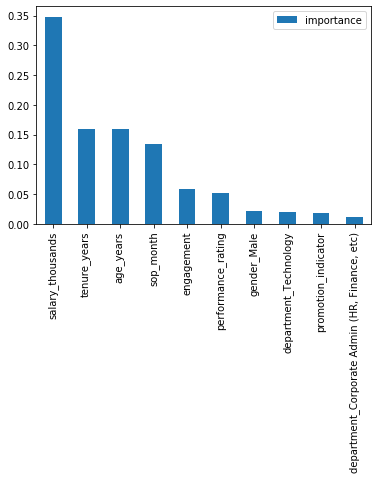

In [184]:
winning_model = GradientBoostingClassifier(n_estimators = 400, min_samples_split = 10, max_depth = 8)
winning_model.fit(X_train, y_train)

feature_importances = pd.DataFrame(winning_model.feature_importances_,
                                       index = df_dummied.iloc[:,:-1].columns,
                                        columns=['importance']).sort_values('importance', ascending=False)

feature_importances[feature_importances['importance'] >= .01].plot.bar()

A few things I want to point out here when interpreting this graph.  First, this is what is “important”, meaning it doesn’t indicate a direction relationship.  For example, saying “more salary means more risk of turnover” is not a correct interpretation.  Rather “salary is the most important variable to this model” is the correct interpretation.  The second point is that you can’t over index too heavily on all items that show up on this graph.  For example, the turnover logic to create this dataset does not mention gender or department variables at all, however it shows them as variables that carry at least some importance.  Why is that?  Think in terms of random chance.  The dataset was created using random number generation, so there is a chance that department or gender plays an impact on turnover behavior.  There is also a chance that it is just noise and not something to read into.

When reading this graph, look for the variables that are significantly higher than the others.  In this, anything below performance rating probably isn’t worth thinking about as an important variable.


## Using our Model to Predict
The entire purpose of building a model is to use it to predict!  To do this, is the same as how we are treating the test dataset (minus the score calculation).  With a turnover model, you’d use all of your employee’s most recent record to then predict out the next X months you have set your target variable for.  Here is some pseudo code to demonstrate.

In [ ]:
newdata_predictions = your_model.predict_proba(X_newdata)[:,1]

## In Summary
Throughout this chapter we went from the beginning of the modeling process where we ingest our raw data and clean it up to the end of the modeling process where we are able to utilize it for future predictions.  Based purely on the amount of code in each section, I hope it has become clear that the majority of the modeling process becomes before you actually build the model.  When you consider the context of HR data, this is going to be even more true.  Most companies do not have their HR data in a single database, cleaned, and ready to be pulled for modeling projects.  It is more likely you’re having to pull your information from multiple sources and still do a significant amount of cleaning.  The general rule of thumb is 80% data clean up and 20% actual modeling.  With HR data, expect that to be closer to 90% data clean up to 10% modeling.

While this may be frustrating, business leaders look to invest in projects and people who prove value.  If you’re able to take your employee data, build a turnover model on it, and create an intervention that reduces turnover by even 0.5%, you’re saving your company an incredible amount of money (regardless of the size of your company).  Showing this type of value is how you can then get additional leverage to push your HR leaders to invest in a data infrastructure that potentially turns your data cleaning to modeling ratio to 70-30 or even 60-40!

This example showed you how to build a turnover model which seems to be the hottest topic.  You can take this code and adjust it for your own company’s data.  Beyond this, the same type of modeling framework can be leveraged for other types of predictions as well!  This is nice because once you get a hang of this type of framework, it helps get you closer to the scalable analytics.  Rather than starting from scratch every time, you’re able to leverage a significant amount of your code from other projects to expedite the development time of the next project!

Throughout my time in the HR analytics space and various interviews, the question about a model that predicts turnover has been the most common.  I hope this chapter gives you a framework and some additional knowledge to feel comfortable building and speaking to a model that predicts turnover!
